## Setup environment

In [2]:
!pip install gensim emoji nltk seaborn torch torchsummary tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import gensim
import gensim.downloader as api
import sklearn.metrics as metrics

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import spacy
from tqdm import tqdm

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

numerous dataframes are created at each step. After using each one we can delete it to save space. Here's the code to do so.

In [3]:
import gc
def free_space(df_no_longer_needed):
    del df_32
    gc.collect()

## Load Dataset

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df_raw = pd.read_csv("./drive/MyDrive/AI-CA5/twitter-suicidal-data.csv")
df_raw.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


## Preprocess Dataset

### Import needed libraries

In [ ]:
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk

### Download packages to use in preprocess steps

In [ ]:
nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])
stop_words = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Preprocessing steps applied on each tweet

In [ ]:
lemmatizer = WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_tweet(text: str) -> list[str]:

    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation)) # To remove punctuations

    text = re.sub(r'\d+', '', text) # To remove digits

    # To remove URLs
    text = re.sub(r'((http|ftp|https):\/\/)?([\w\-_]+)(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?', '', text)

    text = re.sub(r'@\w+', '', text) # To remove tagged usernames

    text = re.sub(r' +', ' ', text) # To remove the spaces in between words

    text = text.strip() # To remove spaces at the begining/end of tweets

    text = emoji.demojize(text) # To replace each emoji with its tag
    text = re.sub(r':\w+:', ' ', text) # To replace emoji tags with space

    text = re.sub(r'\W', ' ', text) # To remove non-word parts

    # To split the tweet into its words
    tokens = word_tokenize(text)

    # To lemmatize each word based on its tag
    tagged_tokens = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word=token, pos=nltk_pos_tagger(tag)) for token, tag in tagged_tokens]

    # To remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

### Preprocess all tweets of the dataframe

In [ ]:
df_raw["preprocessed tweet"] = df_raw["tweet"].apply(lambda x: preprocess_tweet(x))

In [ ]:
df_raw["numof words"] = df_raw["tweet"].apply(lambda x: len(x.split()))
df_raw["numof tokens"] = df_raw['preprocessed tweet'].apply(lambda x: len(x))
df_raw["unique tokens"] = df_raw["preprocessed tweet"].apply(lambda x: list(np.unique(x)))
df_raw["numof unique tokens"] = df_raw["unique tokens"].apply(lambda x: len(x))

Here are some examples of tweets before and after preprocessing steps.

In [ ]:
def show_sample_tweets(df, n):
    sample_df = df.sample(n=n).reset_index(drop=True)
    for i in range(len(sample_df)):
        print("Original Tweet:")
        print(sample_df["tweet"][i])
        print("Processed Tweet:")
        print(" ".join(sample_df["preprocessed tweet"][i]))
        print()

show_sample_tweets(df=df_raw, n=3)

Original Tweet:
i had an abortion and dont want to wake upi am not expecting to gain sympathy by posting this i dont have any sympathy for myself i just dont have anyone to talk to in my life out of fear of being judged i am older 38 this was my 1st time being pregnant i was 7 weeks and terminated my pregnancy 1 week ago w a medical abortion i was with my ex about a year we were having problems and had broken up a few weeks before i found out at 38 i thought i missed my chance at being a mom in a new relationship my bf at time stated he wanted to eventually try and have one child at the time i became pregnant i was not trying i realized we had sex in that fertile window even bought plan b for whatever reason i left it in my car n went away for a few days for work i didnt repurchase it it was not an intelligent move on my part i told my brothers and a 2 friends of my pregnancy not thinking abortion was even an option at the time my ex shocked me he was furious and stated i was ruining h

#### Why do we convert words to lowercase?
Advantages:
- It ensures that are words are treated equally. Actually it doesn't matter wether a word is used at the beggining of a sentence or somewehre else, It means the same.
- It optimizes computational overhead by reducing numof distinct words.

Disadvantages:
- In some special cases, words lost their true maning after casting to lowercases. For example when someone is talking with anger or excitment, he/she might write words in form of all uppercase. It happens rarely and we can ignore its effect.
- Some words might lose their actual meaning after lowercasing. For example *Turkey* the country and *turkey* the bird.

#### Why do we remove numbers?
Advantages:
- Numbers don't give much meaningful information as words.
- Removing them helps to reduce computational dimensionality.

Disadvantages:
- Numbers might matter in some datasets. I don't think it's the case here.

#### Why don't we remove hashtags?
Hashtags actually give a lot of important information to us. Someone with suicidal intention would probably post sad or angry tweets with negative hashtags. People that use similar hashtags are probably more like each other too.

## Visualize size of Tweets

### Box, Violin, Histogram
In the first part i used three charts to gain a better understanding of sizes distributions. These plots indicate that:
- people with suicidal intention write longer tweets.
- people with suicidal intention repeat some words. It means that these key words would probably help to identify suicidal motivations in a tweet.

In [23]:
import plotly.express as px
from plotly.subplots import make_subplots
def visualize_numof_tokens(df, target):
    fig = make_subplots(rows=3, cols=2, column_titles=["Tweets without Suicidal Intention", "Tweets with Suicidal Intention"])
    for i in range(2):
        df_temp = df[df["intention"] == i]
        fig.add_trace(px.histogram(data_frame=df_temp, x=target).data[0], row=1, col=i+1)
        fig.add_trace(px.box(data_frame=df_temp, x="intention", y=target).data[0], row=2, col=i+1)
        fig.add_trace(px.violin(data_frame=df_temp, x="intention", y=target).data[0], row=3, col=i+1)
    fig.update_layout(height=1000, width=1300)
    fig.show()

In [ ]:
visualize_numof_tokens(df=df_raw, target="numof tokens")

In [ ]:
df_raw.groupby("intention")["numof tokens"].describe()

,count,mean,std,min,25%,50%,75%,max
intention,,,,,,,,
0,5121.0,8.969928,6.465071,0.0,4.0,7.0,12.0,38.0
1,3998.0,73.629565,96.628621,0.0,19.0,46.0,95.0,2129.0


In [ ]:
visualize_numof_tokens(df=df_raw, target="numof unique tokens")

In [ ]:
df_raw.groupby("intention")["numof unique tokens"].describe()

,count,mean,std,min,25%,50%,75%,max
intention,,,,,,,,
0,5121.0,8.526460,5.830595,0.0,4.0,7.0,11.0,36.0
1,3998.0,55.466733,57.300592,0.0,17.0,39.0,76.0,774.0


There are 32 tweets with 0 token after preprocessing. It's only logical to remove them.

In [ ]:
numof_tokens_threshold = 0
df_raw = df_raw[df_raw["numof tokens"] > numof_tokens_threshold].reset_index(drop=True)

### Relationship between numof tokens and original words
In the second part i used polynomial regression models to fit a line on the distributions. These plots indicate that:
- There seems to be a linear relationship btween number of words in the raw tweet and number of tokens in the preprocessed tweet. Each processed tweets are almost half size of its original form.
- Strong relationship between number of tokens and number of distinct tokens.


In [ ]:
def polynomial_regression(x, y, degree):
    X = np.column_stack([x**i for i in range(degree + 1)])
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta

def predict(coefficients, X, degree):
    return sum([coefficients[i] * X**i for i in range(degree + 1)])

def train_model(x, y, degree):
    return polynomial_regression(x=x, y=y, degree=degree)

def make_predictions(x, coeffs, degree):
    return predict(coefficients=coeffs, X=x, degree=degree)

import plotly.express as px

def draw_scatter(x_cols, y_cols, degree):
    fig = make_subplots(rows=1, cols=len(x_cols),
                  subplot_titles=[f"{y_cols[i]} predicted by {x_cols[i]}" for i in range(len(x_cols))])
    for i in range(len(x_cols)):
        x = df_raw[x_cols[i]]
        y = df_raw[y_cols[i]]
        coeffs = train_model(x=x, y=y, degree=degree)
        preds = make_predictions(x=x, coeffs=coeffs, degree=degree)

        x_bins = np.linspace(x.min(), x.max(), 100)
        y_values = [predict(coefficients=coeffs, X=x, degree=degree) for x in x_bins]
        fig.add_trace(px.scatter(x=x, y=y).data[0], row=1, col=i+1)
        fig.add_trace(px.line(x=x_bins, y=y_values).update_traces(line_color="purple").data[0], row=1, col=i+1)

    fig.show()

degree = 2
draw_scatter(x_cols=["numof tokens", 'numof unique tokens', "numof unique tokens"], y_cols=["numof words", 'numof tokens', "numof words"], degree=degree)

## Word Cloud

It is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_text_wordcloud(df, target):
    all_words = ""
    for i in range(len(df)):
        all_words += " ".join(df[target][i]) + " "

    wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(all_words)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

### Tweets without Suicidal Intention

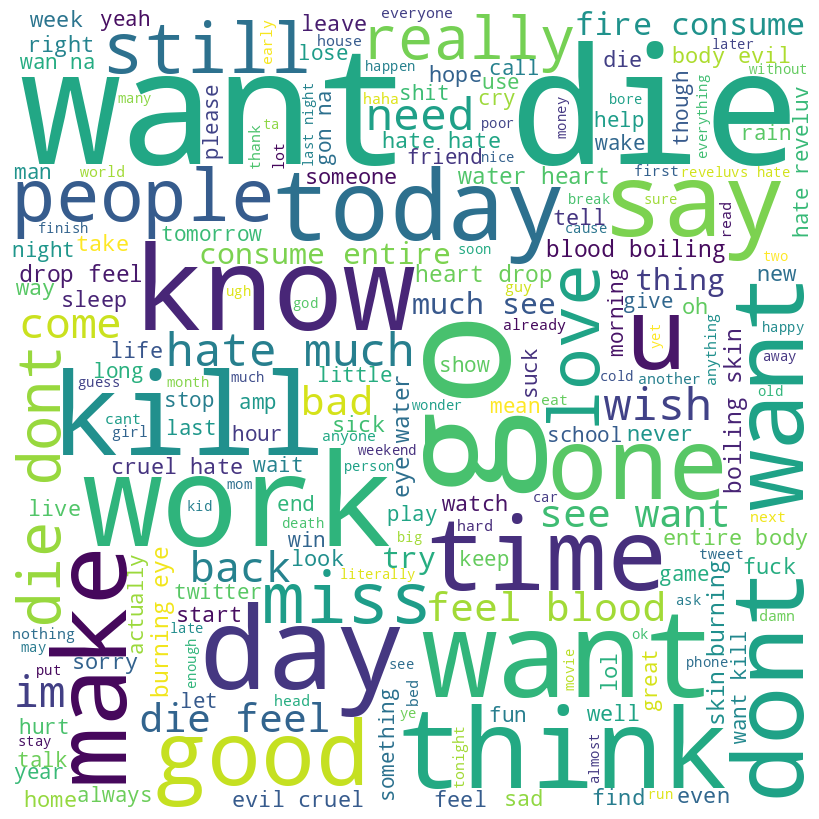

In [ ]:
visualize_text_wordcloud(df=df_raw[df_raw["intention"] == 0].reset_index(drop=True), target="preprocessed tweet")

### Tweets with Suicidal Intention

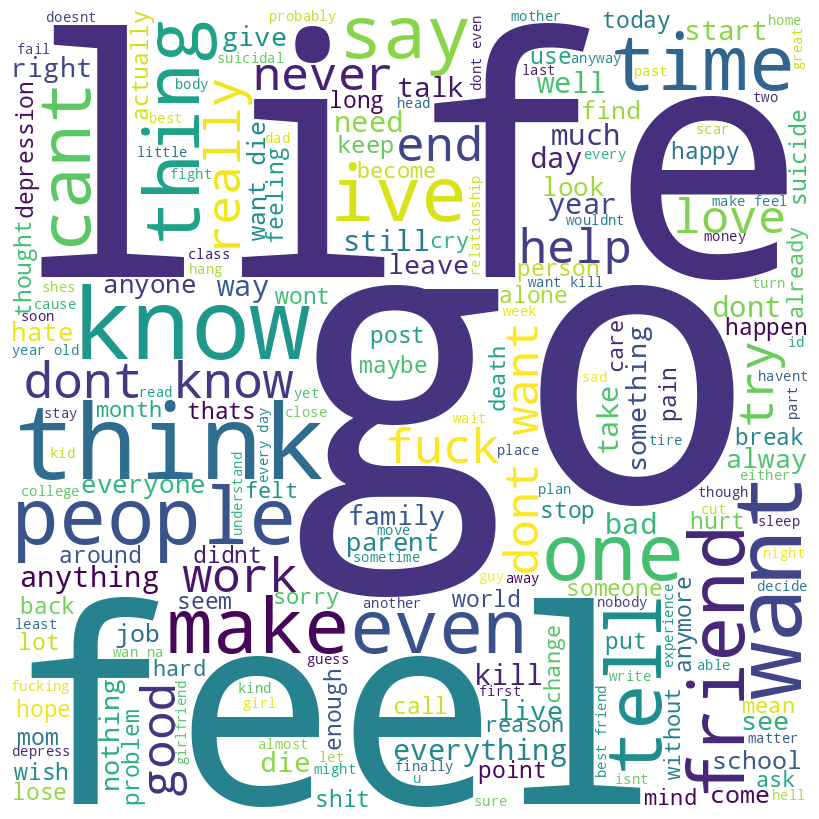

In [ ]:
visualize_text_wordcloud(df=df_raw[df_raw["intention"] == 1].reset_index(drop=True), target="preprocessed tweet")

## Save tokens

### Save preprocessed tweets along with intentions in a new file

from now on, we'll try to save data after each process to save time for future steps.

In [ ]:
tokens_path = "./drive/MyDrive/AI-CA5/tokens.csv"

In [ ]:
df_raw[["preprocessed tweet", "intention"]].to_csv(tokens_path)

### Load preprocessed dataset

- an extra column appeard after storing the dataframe in a csv file. It must be removed.
- When a dataframe is stored as csv file usig Pandas.to_csv method, Lists are converted to a string representation. Here is how to fix it.

In [9]:
import ast
def convert_to_list(list_as_str):
    return ast.literal_eval(list_as_str)

In [ ]:
df_tokens = pd.read_csv(tokens_path)
df_tokens.drop(["Unnamed: 0"], axis=1, inplace=True)
df_tokens.columns = ["tokens", "intention"]
df_tokens["tokens"] = df_tokens["tokens"].apply(lambda x: convert_to_list(x))

## Feature Extraction using Word to Vector

In natural language processing, a word embedding represents words and phrases with a vector of numbers. The representation vector encodes the meaning of the word in such a way that the words that are closer in the vector space are expected to be similar in meaning.

### load the model or download it for the first time

In [ ]:
W2V_PATH = "./drive/MyDrive/AI-CA5/w2v-model"
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


## Plot W2V words

- Pick some random words.
- Find most similar words to each one of them.
- Reduce teh dimension of vectors to two or three for sake of visualizing.
- visualize words using a scatter plot.

In [ ]:
similar_words = dict()
random_topics = ["football", "computer", "music", "sea", "university", "war"]
for topic in random_topics:
    similar_words[topic] = w2v_model.most_similar(topic, topn=3)
    sim_words = [x[0] for x in similar_words[topic]]
    print(f"found three similar words to {topic}: {sim_words}")

found three similar words to football: ['soccer', 'fooball', 'Football']
found three similar words to computer: ['computers', 'laptop', 'laptop_computer']
found three similar words to music: ['classical_music', 'jazz', 'Music']
found three similar words to sea: ['ocean', 'seas', 'oceans']
found three similar words to university: ['universities', 'faculty', 'unversity']
found three similar words to war: ['wars', 'War', 'invasion']


In [ ]:
all_words = []
for topic in random_topics:
    all_words.append(topic)
    for i in range(len(similar_words[topic])):
        all_words.append(similar_words[topic][i][0])

In [ ]:
from sklearn.decomposition import PCA

def reduce_dimensions(n, data):
    pca = PCA(n_components=n)
    reduced_features = pca.fit_transform(data)
    return reduced_features

In [ ]:
random_words_vector = [w2v_model[word] for word in all_words]
df_random_words_vector = pd.DataFrame(random_words_vector)
reduced_df = pd.DataFrame(reduce_dimensions(n=2, data=df_random_words_vector))
reduced_df["word"] = all_words

plotly visualizes data in an interactive way. Therefore we can see the actual label of each data point. As shown below, Words near to each other in the 2-dimensional sapce are also close in meaning.

In [ ]:
px.scatter(data_frame=reduced_df, x=0, y=1, hover_data="word").show()

## Embedding

Each word in token lists is replaced by its represantative vector. But before that we have to make sure all lists are have same size. It's because we're going to feed them into a CNN model and inputs must have the same size.

### How to handle an out-of-vocabulary word?
OOV words are words that were not present in the trained model and thus do not have a corresponding word vector.
- Simplest way is to ignore it. If it's not in the model' vocab, it's probably not important. But that's not always ture. It might be a special less-used word which contains really meaningful information.
- Using a special token for all of them. Like what we did here (replace them with "")
- Replacing them by similar words based on provided information. The model can replace each one by its similar words considering near words to it. It's like when we're reading a hard to understand text and try to guess the meaning of some words based on other words.

In [ ]:
def get_word_vectors(tokens, max_tokens):
    all_word_vectors = []
    i = 0
    while i < max_tokens:
        if tokens[i] in w2v_model:
            word_vector = w2v_model[tokens[i]]
        else:
            word_vector = np.zeros(w2v_model.vector_size)

        all_word_vectors.append(word_vector)
        i += 1

    return all_word_vectors

def pad(tokens, max_tokens):
    while len(tokens) < max_tokens:
        tokens.append("")
    return tokens


def proc_dataset(df, token_col, max_tokens):
    # Empty token lists are already removed

    # Add padding
    print("Adding paddings as needed...", end="\r")
    df[token_col] = df[token_col].apply(lambda x: pad(tokens=x, max_tokens=max_tokens))
    print(" " * 30, end="\r")
    print("Paddings are added")

    # Get embedding's vectors
    print("Creating embedded vectors...", end="\r")
    df[token_col] = df[token_col].apply(lambda x: get_word_vectors(tokens=x, max_tokens=max_tokens))
    print(" " * 30, end="\r")
    print("Vectors are prepared.")

    return df


def seq_report(df_token):
    length_all = df_token.apply(lambda x: len(x)).tolist()

    print(f"Sequence Length Report")
    print(f":::::MAX  LENGTH:::[{np.max(length_all):^4}]")
    print(f":::::MIN  LENGTH:::[{np.min(length_all):^4}]")
    print(f":::::MEAN LENGTH:::[{int(np.mean(length_all)):^4}]")

    all_tokens = set()
    for token_set in df_token.tolist():
        all_tokens = all_tokens.union(set(token_set))
    unique_tokens_count = len(all_tokens)
    valid_tokens = sum(1 if token in w2v_model else 0 for token in all_tokens)
    print("Sequence Tokenization Report")
    print(f":::::All Unique Tokens:::[{unique_tokens_count:^5}]")
    print(f":::::All Valid Tokens:::[{valid_tokens:^5}]")
    print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")



This function processes all the tweets.

In [ ]:
def process_and_embed_tweets(df, token_col, max_tokens):
    print(f"Max numof tokens: {max_tokens}")
    print("Processing dataset...")
    df = proc_dataset(df=df, token_col=token_col, max_tokens=max_tokens)
    print(" "*30, end="\r")
    print("Dataset is processed.")
    return df

In order to save some time i stored processed tweets in files and loaded each one when needed.

In [ ]:
import pickle

def save_as_pkl_file(df, path):
    with open(path, 'wb') as file:
        pickle.dump(df, file)

# save_as_pkl_file(path='./drive/MyDrive/AI-CA5/processed-64.pkl', df=df_all[["64 tokens", "intention"]])

def load_pkl_file(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

# df_64 = load_pkl_file(path='./drive/MyDrive/AI-CA5/processed-64.pkl')
# df_64.columns = ["tokens", "intention"]

## Context Window

### Using a context window to cover even the longest tweet.
#### Advantages
- More context: Larger window sizes provide the model with more context, enabling it to capture more complex patterns and dependencies within the text.
- Improved understanding: Greater context can improve the model's understanding of the text, potentially resulting in better performance.
- Better representation learning: The increased context can help the model
#### Disadvantages
- Higher computational complexity: Larger window sizes lead to more computations and increased memory requirements, making the model more slower to train and run.
- Potential noise and ambiguity: Including more context can sometimes introduce noisy information, making it harder for the model to focus on the essential parts of the text.
- Overfitting: If not properly regularized, a model with a larger window size might overfit the training data, leading to poor generalization on unseen data.

## Split Data into Train and Test

We need both train and test data to fit a model and then evaluate its performance on new unseen data. This function first shuffles the dataframe to ensure randomness. Then the training and testing datasets are separated based on the given ratio. Most of the data must be used in fitting the model but not so much that there wouldn't be enough data to evaluate the trained model. Therefore we use 80-20 or 90-10 proportion of train/test data.

In [ ]:
def split_train_test(df, feature, target, train_size):
    feature_data = df[feature].values

    feature_data = np.array([np.array(arr) for arr in feature_data])

    target_data = df[target].to_numpy()

    shuffled_indices = np.random.permutation(len(feature_data))
    shuffled_feature_data = feature_data[shuffled_indices]
    shuffled_target_data = target_data[shuffled_indices]

    train_test_split_index = int(len(feature_data) * train_size)

    X_train = shuffled_feature_data[:train_test_split_index]
    y_train = shuffled_target_data[:train_test_split_index]
    X_test = shuffled_feature_data[train_test_split_index:]
    y_test = shuffled_target_data[train_test_split_index:]

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    return X_train, X_test, y_train, y_test

### How to deal with words that are unknown to the model?

## Convolutional Neural Network

### SGD & Adam oprimizer
Stochastic Gradient Descent and Adaptive Moment Estimation (Adam) are used in training neural networks, including Convolutional Neural Networks.
#### SGD
The basic idea is to update the model's parameters in the direction that minimizes the loss function using gradient descent.
It uses a randomly shuffled subset of the data in each iteration (stochastic) to compute the gradients.
It's computationally faster and converges quickly for large datasets, especially when combined with momentum-based techniques.
#### Adam
Adam is an extension of the SGD method and is often considered one of the best optimizers for deep learning models. It combines the advantages of other optimizers like AdaGrad and RMSProp.
It adaptively adjusts the step size for each parameter using estimates of the gradient's first and second moments (mean and variance), resulting in an individual learning rate for each parameter.
Adam generally outperforms SGD as it converges faster, especially for large neural networks with many parameters.
#### Comparison
SGD is simpler and computationally efficient but may require careful tuning of the learning rate and momentum. On the other hand, Adam is more adaptive and efficient at converging, but it can sometimes generalize poorly on unseen data if not appropriately regularized.

### Cross Entropy loss function
It measures the dissimilarity between two probability distributions: the predicted probabilities and the actual labels. The goal is to minimize the cross-entropy loss, which leads to a better classification model.
It's used when we have multiple classes, and our model outputs probabilities for each class. The class with the highest probability is considered the predicted class. It helps to adjust the model's parameters so that the predicted probabilities get closer to the actual labels.

Mathematically, for a single training example with true label $y$ and predicted probability $p$, the cross-entropy loss can be expressed as:
$$ L = y \log(\frac{1}{p}) + (1-y) \log(\frac{1}{1-p}) \quad \to \quad L = -y \log(p) - (1-y) \log(1-p)$$
Here, $y$ is a binary indicator (0 or 1) for the class label, and $p$ is the predicted probability that the example belongs to class 1. The first term corresponds to the loss when the example is of class 1, and the second term corresponds to the loss when the example is of class 0.
In practice, we usually deal with multi-class classification problems. Let's say we have $C$ classes. The cross-entropy loss for a single example with true label $\mathbf{y} = (y_1, y_2, ..., y_C)$ and predicted probabilities $\mathbf{p} = (p_1, p_2, ..., p_C)$ is given by:
$$ L = \sum_{c=1}^{C} y_c \log(\frac{1}{p_c}) \quad \to \quad L = -\sum_{c=1}^{C} y_c \log(p_c)$$
Here, $y_c$ is a binary indicator (0 or 1) for class $c$, and $p_c$ is the predicted probability for class $c$. The sum runs over all $C$ classes.
The goal of training a classification model is to minimize the cross-entropy loss, which leads to better predicted probabilities that are closer to the true labels. This is achieved by adjusting the model's parameters through an optimization algorithm such as SGD or Adam.

### Kernel Size
also known as filter size, in a CNN represents the size of the matrix that is used to slide over the input during the convolution operation.

#### Small kernel size
- captures local patterns.
- Might miss on capturing larger dependencies.
- less complex.
- involves fewer parameters, making the model more computationally efficient and less prone to overfitting.

#### Large kernel size
- captures general patterns. However, this comes with the cost of increased complexity and a higher risk of overfitting.
- Captures large dependencies between neurons.
- involves more parameters which increases the model's complexity.

#### Comparison
- Larger kernel sizes can capture more significant patterns and spatial context but may struggle to distinguish small details. Smaller kernel sizes can capture finer details but might miss larger patterns.
Smaller kernel sizes require more channels or deeper architectures, increasing the model's complexity and training time.

### Reduction of convolution output
We reduced them using Feed Forward layers instead of the convolution directly, and the advantages this approach provides:
- Flexibility: Feed Forward layers offer more flexibility in terms of the operations that can be applied to the data. In contrast, reducing the output of the convolution might limit the operations to simple pooling or striding techniques.
- Non-linearity: Convolutional layers often have linear activation functions. By introducing Feed Forward layers, you can add non-linearity, which helps in capturing complex patterns and enhancing the model's expressiveness.
- Reducing overfitting: Feed Forward layers can help reduce overfitting by providing a form of regularization.
- using Feed Forward layers for reduction enables the model to adaptively learn the most effective way to compress the data.
- It also provides more flexibility and compatibility when designing and integrating different neural network architectures.

### Activation Functions

- $ relu(x) = max(0, x) $

- $ \text{Softmax}(x_i) = \frac{e^{z_i}}{\sum_{j = 1}^n e^{z_j}} $

## Regularization

Regularization is a process of introducing additional information to prevent overfitting. CNNs use various types of regularization. In this assignmnet we used two f them. Dropout and Batch normalization.

### Dropout
Dropout
At each training stage, individual nodes are either "dropped out" of the net (ignored) with probability $ 1 - p $ or kept with probability $ p $, so that a reduced network is left; incoming and outgoing edges to a dropped-out node are also removed. Only the reduced network is trained on the data in that stage. The removed nodes are then reinserted into the network with their original weights.

for input neurons, $ p $ is typically high because information is directly lost when input nodes are ignored.

for training neurons, $ p $ is usually around 0.5.

### Batch Normalization
Batch normalization is a method used to make training of a NN model faster and more stable through normalization of the layers' inputs by re-centering and re-scaling.

Let $ x $ be the input to a layer in a neural network. Batch Normalization transforms the input through the following steps:
- Calculate the mean $ \mu $ and standard deviation $ \sigma $ of the input $ x $ over a mini-batch.
$$ \mu = \frac{1}{n} \sum_{i=1}^n x_i $$
$$ \sigma^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2 \quad \to \quad \sigma = \sqrt{\sigma^2} $$
- Normalize the input $ x $ using the mean and standard deviation:
$$ z = \frac{x - \mu}{\sigma} $$
- Apply a scale parameter $ \gamma $ and shift parameter $ \beta $:
$$ BN(x) = \gamma \cdot z + \beta $$.

The parameters $ \gamma $ and $ \beta $ are learnable and are initialized to $ 1 $ and $ 0 $. During training, they are optimized to restore the representational power of the network.

## Build CNN Model using Keras

### Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad

This is the final architecture i used to create CNN model. Before this i made some simpler models without regilarization or with less regularization steps. All results are stored in a csv file.

In [ ]:
def add_layers_to_model(model, input_shape, init_filters, kernel_size, num_classes):
    model.add(Conv1D(filters=init_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    model.add(BatchNormalization())

    model.add(Conv1D(filters=2*init_filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv1D(filters=4*init_filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(units=8*init_filters, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=4*init_filters, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=num_classes, activation='softmax'))

    return model

def build_CNN_model(optimizer, input_shape, filters, kernel_size, num_classes, metrics):
    CNN_model = Sequential()
    CNN_model = add_layers_to_model(model=CNN_model, input_shape=input_shape,
                init_filters=filters, kernel_size=kernel_size, num_classes=num_classes)
    CNN_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)

    return CNN_model

This function creates a CNN model, Add some layers to it, Compiles it and then feeds input tweets into it. *history* output of model shows loss information and evaluation metrics.

In [ ]:
def train_model(X_train, X_test, y_train, y_test, optimizer, epochs, input_shape, batch_size, filters, kernel_size, num_classes, metrics):
    print(f"Building model using optimizer {optimizer}")
    model = build_CNN_model(optimizer=optimizer, input_shape=input_shape, filters=filters, kernel_size=kernel_size, num_classes=num_classes, metrics=metrics)
    X_train_tensor = tf.convert_to_tensor(X_train)
    y_train_tensor = tf.convert_to_tensor(y_train)
    X_test_tensor = tf.convert_to_tensor(X_test)
    y_test_tensor = tf.convert_to_tensor(y_test)
    history = model.fit(X_train_tensor, y_train, batch_size=batch_size, epochs=epochs,
                          verbose=1, validation_data=(X_test,y_test))
    return history.history

## Build CNN model using Pytorch

In [ ]:
def calculate_accuracy(outputs, true_labels):
    _, pred_labels = torch.max(outputs, dim=1)
    correct_labels = (pred_labels == true_labels).sum().item()
    return correct_labels / len(true_labels)

In [ ]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device):
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, true_labels in itr:
        inputs = inputs.to(device)

        outputs = model(inputs)

        loss = loss_function(outputs, true_labels)

        test_acc = calculate_accuracy(outputrs=outputs, true_labels=true_labels)
        test_loss = loss.item()
        itr.set_description("(Eval)")
        itr.set_postfix(loss=round(loss.item(), 5), accuracy=round(test_acc, 5))

    return test_loss, test_acc


In [ ]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device,
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)


    model.to(device)

    itr = tqdm(train_loader, total=len(train_loader), leave=False)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        print(f"epoch{epoch}")
        for idx, (inputs, labels) in enumerate(itr, start=1):
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            epoch_acc += torch.sum(preds == labels).item()
            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(epoch_acc, 5),
                )

        model.eval()
        valid_loss, valid_acc = model_eval(
                model=model,
                loader=valid_loader,
                loss_function=loss_function,
                device=device
                )
        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc / len(train_set))
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        print(f"train_loss={epoch_loss / len(train_loader)}")
        print(f"train_acc={epoch_acc / len(train_set)}")
        print(f"valid_loss={valid_loss}")
        print(f"valid_acc={valid_acc}")

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_classes=2, perform_dropout=False, perform_batch_normalization=False):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=300, kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(in_channels=300, out_channels=hidden_size, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=3)
        self.fc1 = nn.Linear(  12672, hidden_size)
        if perform_dropout:
            self.dropout = nn.Dropout(p=0.5)
        if perform_batch_normalization:
            self.batch_norm = nn.BatchNorm1d(num_features=64)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        if perform_batch_normalization:
            x = self.batch_norm(x)
        if perform_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

## Results

The results are stored at this directory. First we'll load and then analyse them.

In [11]:
result_path = "./drive/MyDrive/AI-CA5/res.csv"
df_result = pd.read_csv(result_path)

Same problems occured like when we stored tweets. Let's fix them first.

In [12]:
df_result.drop("Unnamed: 0", axis=1, inplace=True)
for col in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    df_result[col] = df_result[col].apply(lambda x: convert_to_list(x))

Separating some columns to use in this part of analysis.

In [13]:
df_res = df_result[['opt', 'max tokens', 'reg', 'epoch', 'most acc epoch', 'kernel size',
                    'activation', 'train', 'acc min', 'acc max', 'acc growth']]

The file contains result of all a large number of models that i've tested. Let's separate and analyse them some of them

In [15]:
df_res = df_res.loc[[0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21]].reset_index(drop=True)
df_result = df_result.loc[[0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21]].reset_index(drop=True)

## Analyse Models from Different Aspects

In this part we're going to evaluate created models and visualize their performance. This code plots 4 lines for each model. loss value and accuracy on both train and test data.

In [18]:
def print_model_info(df, ind,
                     show_act, show_opt, show_maxt,
                     show_reg, show_growth):
    sep = " "
    amp = 7 - (int(show_act) + int(show_opt) +
               int(show_reg) + int(show_growth) +
               int(show_maxt))
    inf = ""
    if show_act:
        inf += df["activation"][ind] + sep
        inf += "activation function" + sep * amp
    if show_opt:
        inf += df["opt"][ind] + sep
        inf += "optimizer" + sep * amp
    if show_reg:
        inf += df["reg"][ind] + sep
        inf += "regularization" + sep * amp
    if show_maxt:
        inf += str(df["max tokens"][ind]) + sep
        inf += "tokens" + sep * amp
    # # inf += str(df["epoch"][ind]) + sep
    # inf += "epochs" + sep * amp
    if show_growth:
        inf += "acc growth:" + sep
        inf += str(df["acc growth"][ind]) + "%" + sep
        inf += "("
        inf += str(df["acc min"][ind]) + "%" + sep
        inf += "-->" + sep
        inf += str(df["acc max"][ind]) + "%" + ")"

    return inf

def create_lines(x, ys, colors):
    return [px.line(x=x, y=ys[i]).update_traces(line_color=colors[i]).data[0] for i in range(len(colors))]

def show_model_result(df, ind, show_flags):
    fig = make_subplots(cols=1, rows=1)
    x = [i for i in range(df_result["epoch"][ind])]
    ys = [df_result[col][ind] for col in ['loss', 'accuracy', 'val_loss', 'val_accuracy']]
    colors = ["blue", "cyan", "red", "purple"]
    fig.add_traces(create_lines(x=x, ys=ys, colors=colors), rows=1, cols=1)
    return fig

def show_models_result(df, inds, show_flags):
    fig = make_subplots(cols=len(inds), rows=1, subplot_titles=[print_model_info(df, ind, *show_flags) for ind in inds])
    for i in range(len(inds)):
        lines = show_model_result(df=df_result, ind=inds[i], show_flags=show_flags)
        fig.add_traces([lines.data[i] for i in range(4)], rows=1, cols=i+1)
    fig.show()


### 1. Max Tokens
- Models with smaller context window are less complicated and reach their max accuracy in a few epochs. Because of the smaller input, They probably miss some information and are less acuurate.
- Models with a reasonable value of context window contain almost all the important information. Thus they're more accurate.

In [21]:
df_res_low_tokens = df_res[df_res['max tokens'] != 100].loc[[0, 7, 9]]
print("Models with input shape (32/64, 300):")
display(df_res_low_tokens)
df_res_high_tokens = df_res[df_res['max tokens'] == 100]
print("Models with input shape (100, 300):")
display(df_res_high_tokens)

Models with input shape (32/64, 300):


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
0,Adam,32,no,10,2,3,relu,0.9,88.6,90.6,2.0
7,Adam,64,dropout,15,7,5,relu,0.9,90.4,92.3,1.9
9,Adam,64,dropout & Batch,15,6,5,relu,0.9,86.5,91.3,4.8


Models with input shape (100, 300):


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
17,Adam,100,dropout & Batch,15,15,5,relu,0.8,0.6969,0.9004,0.2035


In [25]:
show_models_result(df=df_result, inds=[0, 9, 17], show_flags=[False, False, True, False, False])

### 2. Optimizer
I used the two optimizers which were mentioned in the assignment description.
- At the end Adam optimizer was more accurate.
- Took longer time for SGD to reach a good accuracy.

In [26]:
df_res_adam = df_res[df_res['opt'] == "Adam"].loc[[3, 7, 13]]
print("Models that use Adam optimizer:")
display(df_res_adam)
df_res_sgd = df_res[df_res['opt'] == "SGD"].loc[[2, 14]]
print("Models that use SGD optimizer:")
display(df_res_sgd)

Models that use Adam optimizer:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
3,Adam,64,no,10,3,3,relu,0.9,88.5,91.1,2.6
7,Adam,64,dropout,15,7,5,relu,0.9,90.4,92.3,1.9
13,Adam,32,dropout & Batch,10,8,3,relu,0.8,86.2,91.4,5.2


Models that use SGD optimizer:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
2,SGD,64,no,10,10,3,relu,0.9,83.7,85.8,2.1
14,SGD,32,dropout & Batch,10,9,3,relu,0.8,56.9,89.2,32.3


In [27]:
show_models_result(df=df_result, inds=[2, 3], show_flags=[False, True, False, False, True])

### 3. Regularization
- Regularized models are a bit more accurate on test data while they're not as accurate as previous models on train data. It means that these methods reduced overfitting.
- Regularized models are less complicated and as a result reach their highest accuracy in more number of epochs.

In [28]:
df_res_not_reg = df_res[df_res['reg'] == "no"].loc[[0, 1]]
print("Models without any regularization method:")
display(df_res_not_reg)
df_res_reg = df_res[df_res['reg'] != "no"].loc[[7, 9]]
print("Models using regularization methods:")
display(df_res_reg)

Models without any regularization method:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
0,Adam,32,no,10,2,3,relu,0.9,88.6,90.6,2.0
1,SGD,32,no,10,9,3,relu,0.9,83.4,85.1,1.7


Models using regularization methods:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
7,Adam,64,dropout,15,7,5,relu,0.9,90.4,92.3,1.9
9,Adam,64,dropout & Batch,15,6,5,relu,0.9,86.5,91.3,4.8


In [29]:
show_models_result(df=df_result, inds=[0, 7, 9], show_flags = [False, False, True, True, False])

### 4. Kernel Size
- Models with 3 kernel size worked faster.
- Models with 5 kernel size are more accurate.

In [30]:
df_res_ker3 = df_res[df_res['kernel size'] == 3].loc[[0, 11]]
print("Models with kernel size 3:")
display(df_res_ker3)
df_res_ker5 = df_res[df_res['kernel size'] == 5].loc[[6, 9]]
print("Models with kernel size 5:")
display(df_res_ker5)

Models with kernel size 3:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
0,Adam,32,no,10,2,3,relu,0.9,88.6,90.6,2.0
11,Adam,64,dropout & Batch,10,8,3,relu,0.8,63.5,90.6,27.2


Models with kernel size 5:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
6,Adam,64,no,100,2,5,relu,0.9,87.7,91.0,3.3
9,Adam,64,dropout & Batch,15,6,5,relu,0.9,86.5,91.3,4.8


In [31]:
show_models_result(df=df_result, inds=[0, 6], show_flags=[False, False, True, False, True])

### 5. Activation Function
- Models that used *Relu* were more acuurate
- tanh and sigmoid are more complicated than relu and as a result, These models whould reach high accuracies in more number of epochs than relu models.

In [32]:
df_res_relu = df_res[df_res['activation'] == "relu"].loc[[8, 13]]
print("Models with relu as their activation function:")
display(df_res_relu)
df_res_nrelu = df_res[df_res['activation'] != "relu"]
print("Models with tanh/sigmoid as their activation function:")
display(df_res_nrelu)

Models with relu as their activation function:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
8,SGD,64,dropout & Batch,15,13,5,relu,0.9,82.1,92.3,10.2
13,Adam,32,dropout & Batch,10,8,3,relu,0.8,86.2,91.4,5.2


Models with tanh/sigmoid as their activation function:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
15,Adam,64,dropout & Batch,10,8,5,sigmoid,0.8,43.0,91.4,48.4
16,Adam,64,dropout & Batch,10,10,5,tanh,0.8,43.0,91.4,48.5


In [33]:
show_models_result(df=df_result, inds=[8, 15, 16], show_flags=[True, False, False, False, False])

### 6. Train/Test Ratio
- 90-10 ratio results more accurate model in the early epochs.
- both models are as accurate after the final epoch.
- 90-10 ratio models have a little less generalizion power.

In [34]:
df_res_80 = df_res[df_res['train'] == 0.8].loc[[11, 12]]
print("Models with 80-20 ratio of train/test data:")
display(df_res_80)
df_res_90 = df_res[df_res['train'] == 0.9].loc[[0, 9]]
print("Models with 90-10 ratio of train/test data:")
display(df_res_90)

Models with 80-20 ratio of train/test data:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
11,Adam,64,dropout & Batch,10,8,3,relu,0.8,63.5,90.6,27.2
12,SGD,64,dropout & Batch,10,10,3,relu,0.8,58.5,85.5,27.0


Models with 90-10 ratio of train/test data:


,opt,max tokens,reg,epoch,most acc epoch,kernel size,activation,train,acc min,acc max,acc growth
0,Adam,32,no,10,2,3,relu,0.9,88.6,90.6,2.0
9,Adam,64,dropout & Batch,15,6,5,relu,0.9,86.5,91.3,4.8


In [35]:
show_models_result(df=df_result, inds=[11, 9], show_flags=[False, False, False, False, True])